Implementing VAEs and GANs in pytorch using the following tutorials:
VAE: https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
GAN: https://www.geeksforgeeks.org/generative-adversarial-networks-gans-in-pytorch/

In [22]:
# import required libraries from titanic example
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer, LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import warnings
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.optim as optim
from PIL import Image
import os
warnings.filterwarnings("ignore")
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1


In [4]:
class PlantDataset(Dataset):
    """Custom Dataset for loading plant disease images"""
    def __init__(self, imagepaths, labels, transform=None):
        self.imagepaths = imagepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.imagepaths[idx]
        label = self.labels[idx]

        # Load the image and apply transformations
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

In [5]:
path = path+'/PlantVillage'

In [6]:
image_paths, labels = [], []

for disease in os.listdir(path):
    disease_path = os.path.join(path, disease)

    for image in os.listdir(disease_path):
      if image.startswith("."):
        continue
      image_path = os.path.join(disease_path, image)
      if image_path.lower().endswith((".jpg", ".jpeg", ".png")):
        image_paths.append(image_path)
        labels.append(disease)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

class_names = list(label_encoder.classes_)

In [7]:
print(image_paths[:5])
print(labels[:5])

['/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/1666ae7f-31f9-4faf-8b60-40a1ded014ea___YLCV_GCREC 2236.JPG', '/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/4254afe0-7830-4ffa-bd0d-5d298280275c___UF.GRC_YLCV_Lab 01523.JPG', '/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/7e3bc5f6-9890-4e2e-90a3-cd394eedb6c5___YLCV_NREC 2412.JPG', '/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/13fb8aaa-4db1-405e-86b9-dc482b10b7d8___UF.GRC_YLCV_Lab 02339.JPG', '/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/1559bd4d-251e-4568-9e25-08c1e8fa3674___YLCV_NREC 2384.JPG']
[12 12 12 12 12]


In [8]:
#train test split
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


print("Train size:", len(train_paths))
print("Test size:", len(test_paths))

Train size: 16510
Test size: 4128


In [9]:
class CVAE(nn.Module):
  def __init__(self):
      super(CVAE, self).__init__()
      self.encoder = nn.Sequential(
          nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )
      self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
            transforms.CenterCrop(244)

      )
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [10]:
#apply transformations to avoid model to avoid overfit

train_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
train_dataset = PlantDataset(train_paths, train_labels, transform=train_transform)
test_dataset = PlantDataset(test_paths, test_labels, transform=valid_transform)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:

model = CVAE().to(device)

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
for epoch in range(5):
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, data)
    loss.backward()
    optimizer.step()

    if batch_idx % 99 == 0:
      print(f"Epoch [{epoch+1}/{5}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

Epoch [1/50], Step [1/516], Loss: 0.6610
Epoch [1/50], Step [100/516], Loss: 0.5925
Epoch [1/50], Step [199/516], Loss: 0.5731
Epoch [1/50], Step [298/516], Loss: 0.5915
Epoch [1/50], Step [397/516], Loss: 0.7128
Epoch [1/50], Step [496/516], Loss: 0.6118
Epoch [2/50], Step [1/516], Loss: 0.5655
Epoch [2/50], Step [100/516], Loss: 0.6359
Epoch [2/50], Step [199/516], Loss: 0.5224
Epoch [2/50], Step [298/516], Loss: 0.6795
Epoch [2/50], Step [397/516], Loss: 0.5786
Epoch [2/50], Step [496/516], Loss: 0.6218
Epoch [3/50], Step [1/516], Loss: 0.6072
Epoch [3/50], Step [100/516], Loss: 0.5239
Epoch [3/50], Step [199/516], Loss: 0.5111
Epoch [3/50], Step [298/516], Loss: 0.7402
Epoch [3/50], Step [397/516], Loss: 0.5481
Epoch [3/50], Step [496/516], Loss: 0.6112
Epoch [4/50], Step [1/516], Loss: 0.5841
Epoch [4/50], Step [100/516], Loss: 0.6474
Epoch [4/50], Step [199/516], Loss: 0.5387
Epoch [4/50], Step [298/516], Loss: 0.6149
Epoch [4/50], Step [397/516], Loss: 0.5718
Epoch [4/50], Step 

<Figure size 1600x1200 with 0 Axes>

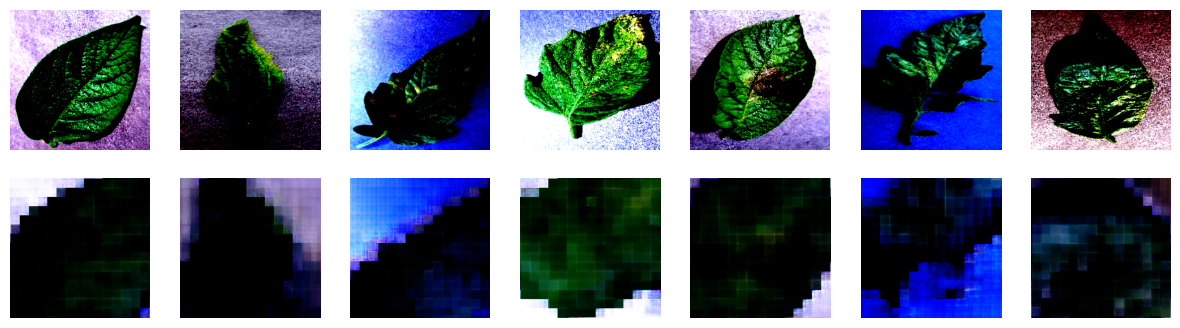

In [31]:
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break

import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

Now GAN

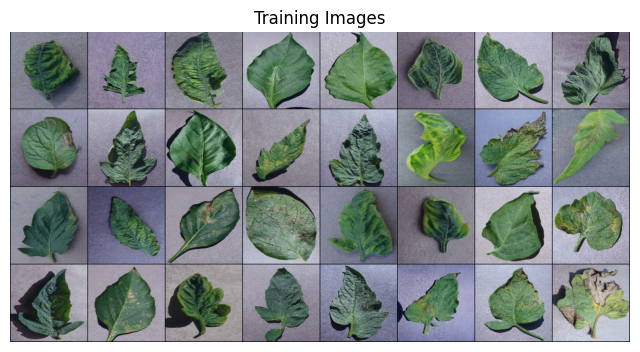

In [34]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [16]:


# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.main = nn.Sequential(
            nn.Linear(noise_dim, 7 * 7 * 256),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, 5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 5, stride=2, padding=2, output_padding=1),
            nn.Tanh(),
            transforms.CenterCrop(244)
        )

    def forward(self, x):
        return self.main(x)


In [17]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Linear( 61 * 61 *128, 1)
        )

    def forward(self, x):
        return self.main(x)

In [18]:
# Noise dimension
NOISE_DIM = 10

# Generator and discriminator
generator = Generator(NOISE_DIM)
discriminator = Discriminator()

In [19]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

In [20]:
#  Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 128

In [23]:
# Training Loop

# Lists to keep track of progress
img_list = None
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(1):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):
        real_images, _ = data
        real_images = real_images.to(device)

        #train discriminator
        discriminator_optimizer.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1, device=device)
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, real_labels)
        real_loss.backward()

        #train discriminator with fake images
        noise = torch.randn(real_images.size(0), NOISE_DIM, device=device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(real_images.size(0), 1, device=device)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_labels)
        fake_loss.backward()
        discriminator_optimizer.step()

        #train generator
        generator_optimizer.zero_grad()
        fake_labels = torch.ones(real_images.size(0), 1, device=device)
        fake_outputs = discriminator(fake_images)
        gen_loss = criterion(fake_outputs, fake_labels)
        gen_loss.backward()
        generator_optimizer.step()


        # Output training stats
        # Print losses
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], '
                  f'Discriminator Loss: {real_loss.item() + fake_loss.item():.4f}, '
                  f'Generator Loss: {gen_loss.item():.4f}')
        img_list = vutils.make_grid(fake_images[:64], padding=2, normalize=True).cpu()



Starting Training Loop...
Epoch [1/5], Step [1/516], Discriminator Loss: 0.0040, Generator Loss: 9.7253
Epoch [1/5], Step [101/516], Discriminator Loss: 0.0017, Generator Loss: 19.3868
Epoch [1/5], Step [201/516], Discriminator Loss: 0.0007, Generator Loss: 11.5442
Epoch [1/5], Step [301/516], Discriminator Loss: 3.1183, Generator Loss: 151.3025
Epoch [1/5], Step [401/516], Discriminator Loss: 0.0000, Generator Loss: 40.7543
Epoch [1/5], Step [501/516], Discriminator Loss: 0.0000, Generator Loss: 25.1762


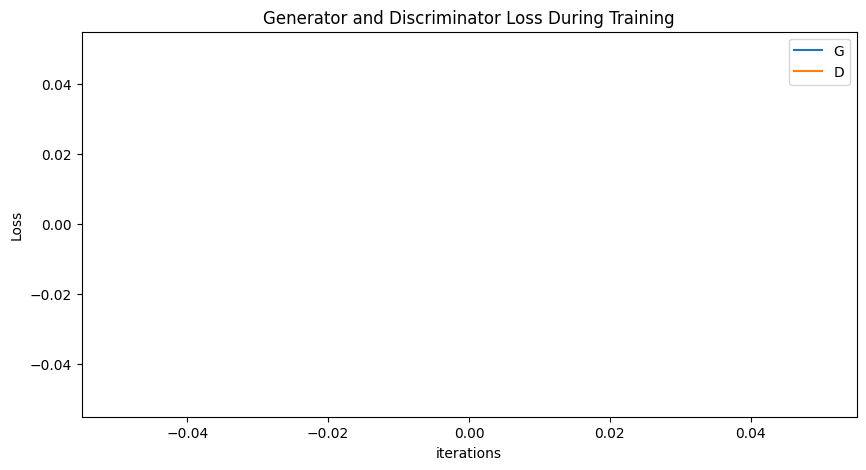

In [24]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

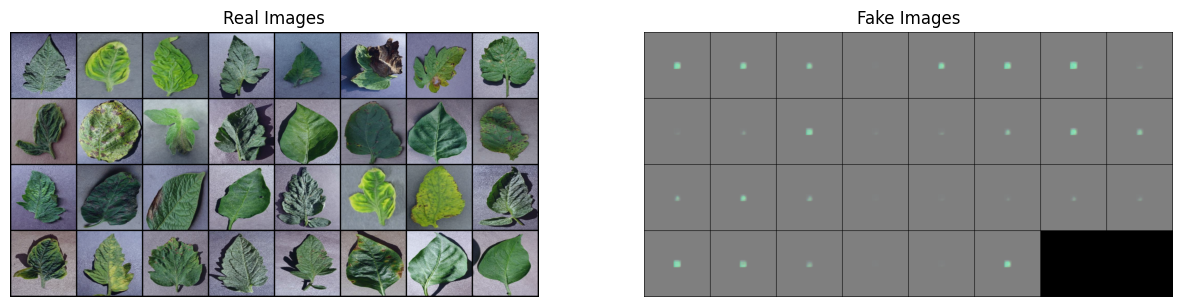

In [26]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list,(1,2,0)))
plt.show()